# Importing Libraries


In [46]:
import os  # file operations
import torch #deep learning library
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader #handle datasets
from torchvision import transforms #image preprocessing(resize,normalize)
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image #open image files

# Preparing Dataset

In [ ]:
class AnimeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        for root, _, files in os.walk(root_dir):
            for f in files:
                if f.lower().endswith(('.png')):
                    self.image_files.append(os.path.join(root, f))
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, index):
        img_path = self.image_files[index]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = AnimeDataset(root_dir='/kaggle/input/anime-faces/data', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Generator

In [48]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, channels=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator


In [49]:
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        out = self.main(input)
        return out.view(-1, 1).squeeze(1) 

# Training Loop

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"

GenNet = Generator().to(device)
DiscNet = Discriminator().to(device)

criterion = nn.BCEWithLogitsLoss()

OptimizerG = optim.Adam(GenNet.parameters(), lr=0.0002, betas=(0.5, 0.999))
OptimizerD = optim.Adam(DiscNet.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, 100, 1, 1, device=device)

num_epochs = 50

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Train Discriminator
        DiscNet.zero_grad()
        
        # Real images
        real_images = data.to(device)
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, device=device)
        
        output_real = DiscNet(real_images)
        errD_real = criterion(output_real, real_labels)
        errD_real.backward()

        # Fake images
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = GenNet(noise)
        fake_labels = torch.zeros(batch_size, device=device)
        
        output_fake = DiscNet(fake_images.detach())
        errD_fake = criterion(output_fake, fake_labels)
        errD_fake.backward()
        
        errD = errD_real + errD_fake
        OptimizerD.step()

        # Train Generator
        GenNet.zero_grad()
        output = DiscNet(fake_images)
        errG = criterion(output, real_labels)
        errG.backward()
        OptimizerG.step()

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D:{errD.item():.4f} Loss_G: {errG.item():.4f}')
    
    # Generate sample images
    with torch.no_grad():
        fake = GenNet(fixed_noise).detach().cpu()
        fake = fake / 2 + 0.5

        fig = plt.figure(figsize=(8, 8))
        for j in range(64):
            plt.subplot(8, 8, j+1)
            plt.imshow(np.transpose(fake[j], (1, 2, 0)))
            plt.axis('off')
        plt.savefig(f'generated_epoch_{epoch}.png')
        plt.close()


[0/50][0/337] Loss_D:1.4033 Loss_G: 2.7573
[0/50][50/337] Loss_D:0.8422 Loss_G: 5.7545
[0/50][100/337] Loss_D:1.0124 Loss_G: 4.5261
[0/50][150/337] Loss_D:0.7245 Loss_G: 3.9721
[0/50][200/337] Loss_D:0.5940 Loss_G: 3.6863
[0/50][250/337] Loss_D:0.8163 Loss_G: 4.6738
[0/50][300/337] Loss_D:0.9708 Loss_G: 6.0840
[1/50][0/337] Loss_D:0.7391 Loss_G: 6.0347
[1/50][50/337] Loss_D:0.4899 Loss_G: 4.0926
[1/50][100/337] Loss_D:0.3508 Loss_G: 2.5643
[1/50][150/337] Loss_D:0.5870 Loss_G: 4.2976
[1/50][200/337] Loss_D:0.4958 Loss_G: 3.1795
[1/50][250/337] Loss_D:0.3680 Loss_G: 4.2986
[1/50][300/337] Loss_D:0.9682 Loss_G: 7.4624
[2/50][0/337] Loss_D:0.4851 Loss_G: 5.2665
[2/50][50/337] Loss_D:0.2821 Loss_G: 3.3633
[2/50][100/337] Loss_D:0.5216 Loss_G: 5.1803
[2/50][150/337] Loss_D:0.5114 Loss_G: 3.8499
[2/50][200/337] Loss_D:0.4006 Loss_G: 4.3403
[2/50][250/337] Loss_D:0.3114 Loss_G: 3.2825
[2/50][300/337] Loss_D:0.5332 Loss_G: 4.3399
[3/50][0/337] Loss_D:0.4364 Loss_G: 5.2569
[3/50][50/337] Loss_D

# Save Models

In [51]:
torch.save(GenNet.state_dict(),'Generator.pth')
torch.save(DiscNet.state_dict(),'Discriminator.pth')

# Generate New Anime faces

Enter no. of images you want to generate 1


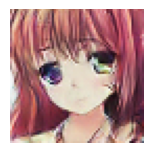

In [ ]:
def generate_anime_faces(num_images):
    GenNet.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, 100, 1, 1, device=device)
        generated_images = GenNet(noise).cpu()

        plt.figure(figsize=(8, 8))
        for i in range(num_images):
            plt.subplot(4, 4, i+1)
            img = generated_images[i] / 2 + 0.5
            plt.imshow(np.transpose(img, (1, 2, 0)))
            plt.axis('off')
        plt.show()
num_images=int(input("Enter no. of images you want to generate"))
generate_anime_faces(num_images)